In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import gc

random.seed(2024)

In [2]:
# Check if GPU is available 
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Directory paths
# train_dir = os.path.expanduser('../train_balanced') # balanced data
train_dir = os.path.expanduser('../raw_data/fer2013/train') # raw data
test_dir = os.path.expanduser('../raw_data/fer2013/test')

# Define a function to load the balanced data
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                labels.append(label)
    return images, labels

# Load training and testing images
train_images, train_Classs = load_images_from_directory(train_dir)
test_images, test_Classs = load_images_from_directory(test_dir)


print(f"Loaded {len(train_images)} training images.")
print(f"Loaded {len(test_images)} testing images.")

# Check the train and test data
print({x: train_Classs.count(x) for x in set(train_Classs)})
print(np.array(train_images).shape)

print({x: test_Classs.count(x) for x in set(test_Classs)})
print(np.array(test_images).shape)

# set up X, y of train and test
train_Class = np.array(train_Classs)
train_images = np.array(train_images)

test_Class = np.array(test_Classs)
test_images = np.array(test_images)


Loaded 28709 training images.
Loaded 7178 testing images.
{'sad': 4830, 'fear': 4097, 'surprise': 3171, 'happy': 7215, 'neutral': 4965, 'disgust': 436, 'angry': 3995}
(28709, 48, 48)
{'sad': 1247, 'fear': 1024, 'surprise': 831, 'happy': 1774, 'neutral': 1233, 'disgust': 111, 'angry': 958}
(7178, 48, 48)


In [4]:
label_map = {}
for i, label in enumerate(set(train_Class).union(set(test_Class))):  # Get unique labels
    label_map[label] = i

# Convert string labels to numerical indices
train_Class = torch.tensor([label_map[label] for label in train_Class]).long()
test_Class = torch.tensor([label_map[label] for label in test_Class]).long()

# Convert to PyTorch tensors
train_images = torch.from_numpy(train_images).float()
test_images = torch.from_numpy(test_images).float()

# Ensure the grayscale images have the correct shape (N, 1, H, W)
train_images = train_images.unsqueeze(1)  # Add channel dimension
test_images = test_images.unsqueeze(1)

In [26]:
# Create DataLoader
random.seed(2024)
torch.manual_seed(2024)
trainloader = DataLoader(TensorDataset(train_images, train_Class), batch_size=32, shuffle=True)
testloader = DataLoader(TensorDataset(test_images, test_Class), batch_size=32, shuffle=True)

In [31]:
# Define a more complex CNN model for 48x48 grayscale images
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 input channel
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25),
            # nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.MaxPool2d(2, 2),
            # nn.AvgPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.25),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.25),
            nn.ReLU(),
            # nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*6*6, 512), # Adjusted for the output size
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.25),
            
            # nn.Linear(1024, 512),
            # nn.BatchNorm1d(512),
            # nn.ReLU(),
            # nn.Dropout(0.25),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            # nn.Linear(256, 128),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            
            nn.Linear(256, 7)  # Assuming 7 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        x = torch.softmax(x, dim=1)
        return x

Epoch [1/50], Train Accuracy: 37.73729492493643%, Test Accuracy: 44.608526051825024%, Train Loss: 1.7853, Test Loss: 1.7155, Time: 11.36 seconds
Epoch [2/50], Train Accuracy: 47.89787174753562%, Test Accuracy: 48.815826135413765%, Train Loss: 1.6854, Test Loss: 1.6739, Time: 10.97 seconds
Epoch [3/50], Train Accuracy: 52.34595423038072%, Test Accuracy: 51.0587907495124%, Train Loss: 1.6428, Test Loss: 1.6497, Time: 10.88 seconds
Epoch [4/50], Train Accuracy: 55.27534919363266%, Test Accuracy: 52.54945667316802%, Train Loss: 1.6126, Test Loss: 1.6333, Time: 10.81 seconds
Epoch [5/50], Train Accuracy: 57.56383015779024%, Test Accuracy: 54.10977988297576%, Train Loss: 1.5901, Test Loss: 1.6206, Time: 10.81 seconds
Epoch [6/50], Train Accuracy: 59.47960569856143%, Test Accuracy: 54.44413485650599%, Train Loss: 1.5707, Test Loss: 1.6152, Time: 10.82 seconds
Epoch [7/50], Train Accuracy: 61.106273294088965%, Test Accuracy: 55.23822791864029%, Train Loss: 1.5543, Test Loss: 1.6109, Time: 10.7

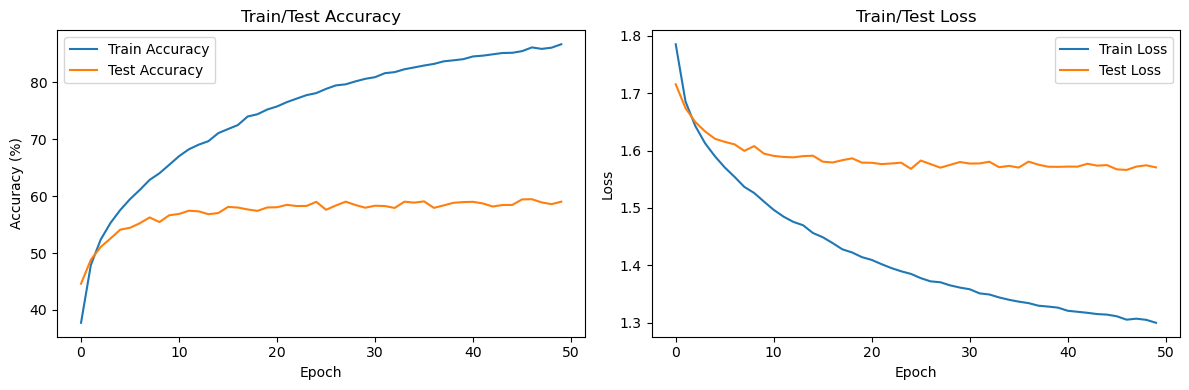

In [32]:
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Define the loss function

# two different optim methods
# optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.6)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Lists to store accuracy values
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

# Train the model
num_epochs = 50
for epoch in range(num_epochs):  # loop over the dataset multiple times
    # ... training loop ...
    start_time = time.time()
    
    # Training loop 
    running_loss = 0  # Initialize running loss for the epoch
    
    correct = 0
    total = 0
    
    # Calculate training accuracy and loss
    total = 0
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        running_loss += loss.item()  # Accumulate loss
        
    train_accuracy = 100 * correct/total
    train_accuracies.append(train_accuracy)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_loss / len(trainloader)
    train_losses.append(epoch_train_loss)

    # Calculate test accuracy and loss
    # testing loop 
    running_loss = 0  # Initialize running loss for the epoch
    
    correct = 0
    total = 0
    
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        running_loss += loss.item()  # Accumulate loss
        
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    
    # Calculate average training loss for the epoch
    epoch_test_loss = running_loss / len(testloader)
    test_losses.append(epoch_test_loss)
    
    end_time = time.time()  # Record the end time of the epoch
    epoch_time = end_time - start_time  # Calculate the epoch time
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Time: {epoch_time:.2f} seconds')

# Plot the accuracy and loss changes
plt.figure(figsize=(12, 4))  # Adjust figure size if needed

plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train/Test Accuracy')
plt.legend()

plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Test Loss')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [ ]:
# model summarization
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'CNN_Best_Model.pth')

# load model
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('CNN_Best_Model.pth', weights_only=True))
# model.eval()

RuntimeError: Error(s) in loading state_dict for VGG:
	Missing key(s) in state_dict: "features.2.weight", "features.2.bias", "features.5.weight", "features.5.bias", "features.7.weight", "features.7.bias", "features.10.weight", "features.10.bias", "features.12.weight", "features.12.bias", "features.14.weight", "features.14.bias", "features.17.weight", "features.17.bias", "features.19.weight", "features.19.bias", "features.21.weight", "features.21.bias", "features.24.weight", "features.24.bias", "features.26.weight", "features.26.bias", "features.28.weight", "features.28.bias", "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias", "classifier.6.weight", "classifier.6.bias". 
	Unexpected key(s) in state_dict: "features.3.weight", "features.3.bias", "features.6.weight", "features.6.bias", "features.9.weight", "features.9.bias", "features.13.weight", "features.13.bias", "classifier.7.weight", "classifier.7.bias", "classifier.10.weight", "classifier.10.bias", "classifier.1.weight", "classifier.1.bias", "classifier.4.weight", "classifier.4.bias". 
	size mismatch for features.0.weight: copying a param with shape torch.Size([32, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 3, 3, 3]).
	size mismatch for features.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).